In [18]:
%matplotlib inline
import os
import pandas
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
import numpy
import math
import itertools 
from scipy.stats import ttest_ind
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats
from sklearn import preprocessing
import seaborn as sns

##### Представление данных

In [19]:
mir_ratio_column = "miR_Ratio"
mir_ratio_2_column = "2_miR Ratio"
hemscore_column = "Hem_Score"
gender_column = "Gender"
diabetes_column = "Diabetes"
age_column = "Age"

##### Обработка данных

In [12]:
class SignificantMicroRNAFinder(object):

    def __init__(
            self, path, mir_ratio_2_theshold=40000, 
            housekeeping_gene="Ct_hsa-miR-16-5p", 
            special_housekeeping_gene=None,
            special_miRNA=None,
            output_files_folder="results/temp",
            output_files_prefix="mir16_hk_",
    ):
        self.path = path
        self.mir_ratio_2_theshold = mir_ratio_2_theshold
        self.housekeeping_gene = housekeeping_gene
        self.special_housekeeping_gene = special_housekeeping_gene
        self.special_miRNA = special_miRNA
        
        self.output_files_folder = output_files_folder
        self.output_files_prefix = output_files_prefix
        if not os.path.exists(self.output_files_folder):
            os.makedirs(self.output_files_folder)
        self.output_prefix = os.path.join(self.output_files_folder, self.output_files_prefix)
        
        self.data = self.prepare_data()
        self.data = self.normalize_expression(self.data)

        
    def normalize_expression(self, df):
        self.norm_exp_cols = []
        exp_cols = [col for col in df.columns if "Ct_" in col]
        for col in exp_cols:
            df[f"{col}_normalized"] = df.apply(
                lambda x: 
                    2**x[col]/2**x[self.housekeeping_gene]
                    # 2**x[self.housekeeping_gene]/2**x[col]
                    if self.special_miRNA is None 
                        or col not in self.special_miRNA
                        or self.special_housekeeping_gene is None 
                        or pandas.isnull(x[self.special_housekeeping_gene])
                    else 
                        2**x[col]/2**x[self.special_housekeeping_gene], 
                        # 2**x[self.special_housekeeping_gene]/2**x[col], 
                axis=1
            )
            self.norm_exp_cols.append(f"{col}_normalized")

        return df

    def prepare_data(self):
        data = pandas.read_excel(self.path)
        data = data.replace(["Undetermined"], [None])
        data[mir_ratio_2_column] = data[mir_ratio_column].map(lambda x: 2**x)

        data.plot.scatter(x=hemscore_column, y=mir_ratio_2_column, title="Before filtering")

        data = self.filter_samples(data)
        data.plot.scatter(x=hemscore_column, y=mir_ratio_2_column, title="After filtering")

        return data


    def filter_samples(self, data):
        return data[data[mir_ratio_2_column] < self.mir_ratio_2_theshold]
    
    @staticmethod
    def highlight_cells(value, threshold=0.1, below=True):
        if below:
            if isinstance(value, float) and abs(value) <= threshold:
                return 'background-color: green'
        else:
            if isinstance(value, float) and abs(value) >= threshold:
                return 'background-color: green'
        
        return 'background-color: white'

    def regression_with_confounding_factors(
        self, group_column="Group",
        confounding_factors=[
            hemscore_column,
            #gender_column,
            diabetes_column,
            age_column,
            mir_ratio_column
        ],
        groups=True
    ):
        le = preprocessing.LabelEncoder()
        
        data = self.data.copy(deep=True)
        
        
        potential_microRNAs = set(self.norm_exp_cols) - set([self.housekeeping_gene + "_normalized"])
        if self.special_housekeeping_gene:
            potential_microRNAs -= set([self.special_housekeeping_gene + "_normalized"])
        
        # correlation between variables
        corr = data[list(potential_microRNAs) + confounding_factors].corr()
        sns.heatmap(corr)
        
        output_suffix = "_%s.xlsx" % "_".join(confounding_factors)

        # Create linear regression object
        lr_scores = pandas.DataFrame()
        regr = linear_model.LinearRegression()
        log2ratio = pandas.DataFrame()
        if groups:
            for group1, group2 in sorted(itertools.combinations(sorted(data[group_column].dropna().unique().tolist()), 2)):
                comparison_name = f"{group1}_vs_{group2}"
                res = {}
                l2r = {}
                for variable in list(potential_microRNAs):
                    # Train the model using the training sets
                    subdf = data[data[group_column].isin([group1, group2])].dropna(subset=confounding_factors + [variable])
                    X = subdf[list(set([variable] + confounding_factors))]

                    y = le.fit(subdf[group_column]).transform(subdf[group_column])

                    X2 = sm.add_constant(X)
                    est = sm.OLS(y, X2)
                    est2 = est.fit()
                    print("\n\n\nComparing groups", group1, group2, "for variable", variable, "\n\n\n")
                    print(est2.summary())
                    res[variable] = est2.pvalues[variable]
                    l2r[variable] = math.log(
                        X.loc[subdf[subdf[group_column] == group1].index][variable].map(lambda x: 1/x).mean() / 
                        X.loc[subdf[subdf[group_column] == group2].index][variable].map(lambda x: 1/x).mean(),
                        2
                    )
                log2ratio = log2ratio.append(pandas.DataFrame(l2r, index=[comparison_name]))
                lr_scores = lr_scores.append(pandas.DataFrame(res, index=[comparison_name]))
                multitests = multipletests(
                    list(lr_scores.T[comparison_name].values), 
                    alpha=0.05, 
                    method="fdr_bh",
                )
                lr_scores.loc[comparison_name + "_mt"] = dict(zip(lr_scores.columns, multitests[1]))
                lr_scores = lr_scores.drop(index=comparison_name)

            lr_scores = lr_scores.sort_index()
            log2ratio = log2ratio.sort_index()

            lr_scores_styler = lr_scores.style.applymap(self.highlight_cells)
            lr_scores_styler.to_excel(f"{self.output_prefix}_group_col_{group_column}_pvalue_significance_{output_suffix}")

            log2ratio_styler = log2ratio.style.applymap(lambda x: self.highlight_cells(x, threshold=2, below=False))
            log2ratio_styler.to_excel(f"{self.output_prefix}_group_col_{group_column}_expression_log2Ratio_{output_suffix}")

            return lr_scores, log2ratio
        else:
            # classic regression
            comparison_name = f"{group_column}"
            res = {}
            l2r = {}
            for variable in list(potential_microRNAs):
                subdf = data.dropna(subset=confounding_factors + [variable])
                X = subdf[list(set([variable] + confounding_factors))]
                y = subdf[group_column]
                X2 = sm.add_constant(X)
                est = sm.OLS(y, X2)
                est2 = est.fit()
                print(est2.summary())
                res[variable] = est2.pvalues[variable]
            
            lr_scores = lr_scores.append(pandas.DataFrame(res, index=[comparison_name]))
            multitests = multipletests(
                list(lr_scores.T[comparison_name].values), 
                alpha=0.05, 
                method="fdr_bh",
            )
            lr_scores.loc[comparison_name + "_mt"] = dict(zip(lr_scores.columns, multitests[1]))
            lr_scores = lr_scores.drop(index=comparison_name)
            
            lr_scores_styler = lr_scores.style.applymap(self.highlight_cells)
            lr_scores_styler.to_excel(f"{self.output_prefix}_group_col_{group_column}_pvalue_significance_{output_suffix}")
            
            return lr_scores, None
                
            

##### Поиска значимо изменяющихся микроРНК в miR_CAD_Database

In [ ]:
finder = SignificantMicroRNAFinder(
    "data/miR_CAD_Database_2019.xlsx", 
    special_housekeeping_gene="Ct_hsa-miR-16-5p_new",
    special_miRNA = [
        "Ct_hsa-miR-146a-5p",
        "Ct_hsa-miR-375", 
        "Ct_hsa-miR-23a-3p", 
        "Ct_miR-451a"
    ],
    output_files_folder="results/miR_CAD_Database_2019"
)
finder.regression_with_confounding_factors()

##### Поиск значимо изменяющихся микроРНК в AF_Database

In [ ]:
finder_af = SignificantMicroRNAFinder(
    "data/miR_AF_Database_2019.xlsx", 
    output_files_folder="results/miR_AF_Database_2019"
)
finder_af.regression_with_confounding_factors()

##### Поиска значимо изменяющихся микроРНК в зависимости от различных рисковых коэффициентов и шкал

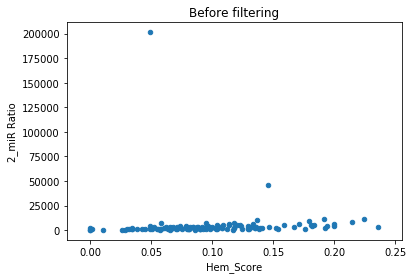

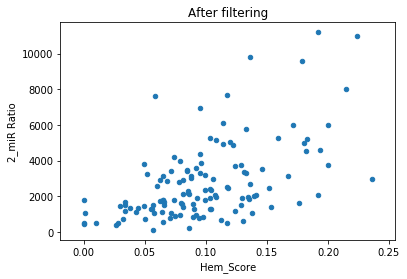

In [14]:
finder = SignificantMicroRNAFinder(
    "data/miR_AF_Database_2019_scales.xlsx", 
    output_files_folder="results/miR_AF_Database_2019_scales"
)




Comparing groups AF_CAD AF_HT for variable Ct_hsa-miR-409-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     2.349
Date:                Sun, 28 Jul 2019   Prob (F-statistic):             0.0565
Time:                        14:45:48   Log-Likelihood:                -29.354
No. Observations:                  50   AIC:                             70.71
Df Residuals:                      44   BIC:                             82.18
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------




Comparing groups AF_CAD CONTR for variable Ct_hsa-miR-21-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     63.36
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           5.51e-19
Time:                        14:45:48   Log-Likelihood:                 17.334
No. Observations:                  50   AIC:                            -22.67
Df Residuals:                      44   BIC:                            -11.20
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.7937
Date:                Sun, 28 Jul 2019   Prob (F-statistic):              0.562
Time:                        14:45:48   Log-Likelihood:                -26.824
No. Observations:                  40   AIC:                             65.65
Df Residuals:                      34   BIC:                             75.78
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           




Comparing groups AF_CAD HT for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     13.24
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           9.27e-08
Time:                        14:45:48   Log-Likelihood:                -11.456
No. Observations:                  48   AIC:                             34.91
Df Residuals:                      42   BIC:                             46.14
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------




Comparing groups AF_HT CONTR for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     21.86
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           6.69e-12
Time:                        14:45:48   Log-Likelihood:                -10.346
No. Observations:                  60   AIC:                             32.69
Df Residuals:                      54   BIC:                             45.26
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------




Comparing groups AF_HT HT for variable Ct_hsa-miR-409-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     3.744
Date:                Sun, 28 Jul 2019   Prob (F-statistic):            0.00571
Time:                        14:45:49   Log-Likelihood:                -33.145
No. Observations:                  58   AIC:                             78.29
Df Residuals:                      52   BIC:                             90.65
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups CONTR CONTR_CAD for variable Ct_hsa-miR-21-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     34.21
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           4.22e-14
Time:                        14:45:49   Log-Likelihood:                 4.3954
No. Observations:                  50   AIC:                             3.209
Df Residuals:                      44   BIC:                             14.68
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------




Comparing groups CONTR HT for variable Ct_hsa-miR-150-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     7.268
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           9.63e-05
Time:                        14:45:49   Log-Likelihood:                -29.380
No. Observations:                  58   AIC:                             68.76
Df Residuals:                      53   BIC:                             79.06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups CONTR_CAD HT for variable Ct_hsa-miR-320a_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     10.29
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           1.74e-06
Time:                        14:45:49   Log-Likelihood:                -14.970
No. Observations:                  48   AIC:                             41.94
Df Residuals:                      42   BIC:                             53.17
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups 0 1 for variable Ct_hsa-miR-409-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     44.81
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           4.68e-26
Time:                        14:45:50   Log-Likelihood:                -22.560
No. Observations:                 128   AIC:                             57.12
Df Residuals:                     122   BIC:                             74.23
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------




Comparing groups 0 1 for variable Ct_hsa-miR-409-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     2.995
Date:                Sun, 28 Jul 2019   Prob (F-statistic):             0.0138
Time:                        14:45:50   Log-Likelihood:                -51.680
No. Observations:                 128   AIC:                             115.4
Df Residuals:                     122   BIC:                             132.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------




Comparing groups 0 1 for variable Ct_hsa-miR-409-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     56.54
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           3.73e-30
Time:                        14:45:50   Log-Likelihood:                -14.576
No. Observations:                 128   AIC:                             41.15
Df Residuals:                     122   BIC:                             58.27
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------




Comparing groups 0 1 for variable Ct_hsa-miR-409-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     56.54
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           3.73e-30
Time:                        14:45:51   Log-Likelihood:                -14.576
No. Observations:                 128   AIC:                             41.15
Df Residuals:                     122   BIC:                             58.27
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

(           Ct_hsa-miR-146a-5p_normalized  Ct_hsa-miR-150-5p_normalized  \
 0_vs_1_mt                       0.231668                      0.868209   
 
            Ct_hsa-miR-19a-3p_normalized  Ct_hsa-miR-21-5p_normalized  \
 0_vs_1_mt                      0.868209                     0.507857   
 
            Ct_hsa-miR-23a-3p_normalized  Ct_hsa-miR-29b-3p_normalized  \
 0_vs_1_mt                      0.612562                      0.514199   
 
            Ct_hsa-miR-320a_normalized  Ct_hsa-miR-328-3p_normalized  \
 0_vs_1_mt                     0.32157                      0.868209   
 
            Ct_hsa-miR-375_normalized  Ct_hsa-miR-409-3p_normalized  \
 0_vs_1_mt                   0.514199                      0.868209   
 
            Ct_miR-451a_normalized  
 0_vs_1_mt                0.514199  ,
         Ct_hsa-miR-146a-5p_normalized  Ct_hsa-miR-150-5p_normalized  \
 0_vs_1                      -1.978596                     -1.836131   
 
         Ct_hsa-miR-19a-3p_normalized  

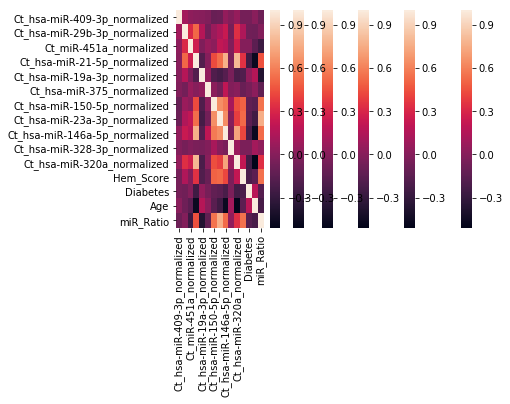

In [16]:
finder.regression_with_confounding_factors()
finder.regression_with_confounding_factors(group_column="CHA2DS2VASc_1")
finder.regression_with_confounding_factors(group_column="CHA2DS2VASc_2")
finder.regression_with_confounding_factors(group_column="SCORE_5")
finder.regression_with_confounding_factors(group_column="ACC_AHA_7,5")
finder.regression_with_confounding_factors(group_column="ACC_AHA_7,5")

                            OLS Regression Results                            
Dep. Variable:                ACC_AHA   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     72.77
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           5.93e-35
Time:                        14:45:51   Log-Likelihood:                -413.09
No. Observations:                 128   AIC:                             838.2
Df Residuals:                     122   BIC:                             855.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

                            OLS Regression Results                            
Dep. Variable:                  SCORE   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.583
Date:                Sun, 28 Jul 2019   Prob (F-statistic):              0.170
Time:                        14:45:51   Log-Likelihood:                -443.51
No. Observations:                 128   AIC:                             899.0
Df Residuals:                     122   BIC:                             916.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

(          Ct_hsa-miR-146a-5p_normalized  Ct_hsa-miR-150-5p_normalized  \
 SCORE_mt                       0.998115                      0.998115   
 
           Ct_hsa-miR-19a-3p_normalized  Ct_hsa-miR-21-5p_normalized  \
 SCORE_mt                      0.998115                     0.981452   
 
           Ct_hsa-miR-23a-3p_normalized  Ct_hsa-miR-29b-3p_normalized  \
 SCORE_mt                      0.998115                      0.998115   
 
           Ct_hsa-miR-320a_normalized  Ct_hsa-miR-328-3p_normalized  \
 SCORE_mt                    0.981452                      0.998115   
 
           Ct_hsa-miR-375_normalized  Ct_hsa-miR-409-3p_normalized  \
 SCORE_mt                   0.998115                      0.998115   
 
           Ct_miR-451a_normalized  
 SCORE_mt                0.998115  , None)

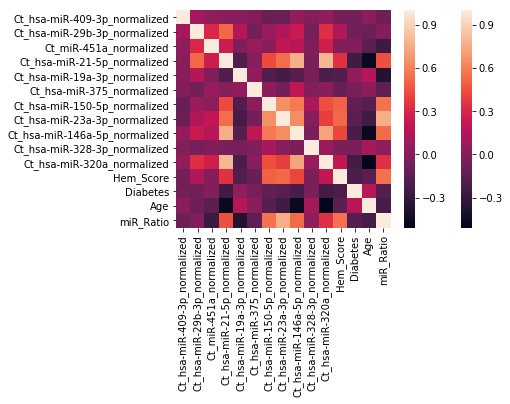

In [17]:
finder.regression_with_confounding_factors(group_column="ACC_AHA", groups=False)
finder.regression_with_confounding_factors(group_column="SCORE", groups=False)